<a href="https://colab.research.google.com/github/girijeshcse/chatbot_savy/blob/anish/notebooks/Initial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
import re, string

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout,LSTM,Embedding, Bidirectional, Flatten, Activation, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Input, Model

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn.utils import resample
import pickle
import os

In [ ]:
drive.mount('/content/gdrive/')
parent_dir = '/content/gdrive/MyDrive/Colab Notebooks/Capstone/'

Mounted at /content/gdrive/


In [ ]:
seed = 7

In [ ]:
data = pd.read_csv(parent_dir+'Data Set - industrial_safety_and_health_database_with_accidents_description.csv')

In [ ]:
data.head(10)

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...
5,5,2016-01-12 00:00:00,Country_02,Local_05,Metals,I,III,Male,Third Party (Remote),Pressurized Systems,During the unloading operation of the ustulado...
6,6,2016-01-16 00:00:00,Country_02,Local_05,Metals,I,III,Male,Employee,Fall prevention (same level),The collaborator reports that he was on street...
7,7,2016-01-17 00:00:00,Country_01,Local_04,Mining,I,III,Male,Third Party,Pressed,"At approximately 04:50 p.m., when the mechanic..."
8,8,2016-01-19 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Third Party (Remote),Others,Employee was sitting in the resting area at le...
9,9,2016-01-26 00:00:00,Country_01,Local_06,Metals,I,II,Male,Third Party,Chemical substances,At the moment the forklift operator went to ma...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                425 non-null    int64 
 1   Data                      425 non-null    object
 2   Countries                 425 non-null    object
 3   Local                     425 non-null    object
 4   Industry Sector           425 non-null    object
 5   Accident Level            425 non-null    object
 6   Potential Accident Level  425 non-null    object
 7   Genre                     425 non-null    object
 8   Employee or Third Party   425 non-null    object
 9   Critical Risk             425 non-null    object
 10  Description               425 non-null    object
dtypes: int64(1), object(10)
memory usage: 36.6+ KB


From the above info, we can see that there are no null values in the data set.

- From the above data, we can see that the first column is merely an index, which we don't need and we can drop it.

- Data column is actually the date, which is not needed for building our NLP model but we can see if we need this for any EDA, later we can drop it.

- Countries column can be used for doing some EDA to see how many accidents happen in a particular country and if some countries have more safety risk compared to others.

- Local column can also be used for some EDA to identify which cities are mode accident prone, will drop it later before model training.

- Industry sector can also be used for EDA to identify industries which have more safety risks.

- Accident level is our target column which we need to be able to predict based on accident description.

- Potential Accident level just indicates what could have been the severity of the accident.

- Genre is basically Gender, we will use this column also for EDA to see distribution among male/female but won't be needed to train our model.

- Employee or Third Party column can also be used for some EDA but not needed for model training.

- Critical Risk basically identifies the area/component where accident has happened.

- Description basically is the textual information about the accident which we will be using to predict the accident level. We will cleanse and convert this text into vectors which will then be passed to our models for training/testing.

In [ ]:
data.groupby(by=['Countries', 'Local']).count().sort_values(['Countries', 'Description'],ascending=False)

Unnamed: 0  Data  ...  Critical Risk  Description
Countries  Local                       ...                            
Country_03 Local_10          44    44  ...             44           44
Country_02 Local_05          59    59  ...             59           59
           Local_08          27    27  ...             27           27
           Local_02          24    24  ...             24           24
           Local_07          14    14  ...             14           14
           Local_12           4     4  ...              4            4
           Local_09           2     2  ...              2            2
Country_01 Local_03          90    90  ...             90           90
           Local_01          57    57  ...             57           57
           Local_04          56    56  ...             56           56
           Local_06          46    46  ...             46           46
           Local_11           2     2  ...              2            2

[12 rows x 9 columns]

From the above distribution we can see that the most number of accidents have happened in Local_03 from Country_01 followed by Local_05 from Country_02.


If we look closely into the above data, Country_01 has more accidents across different cities compared to other two countries.

With this observation, I think we can say that Country_01 is less safe compared to others.

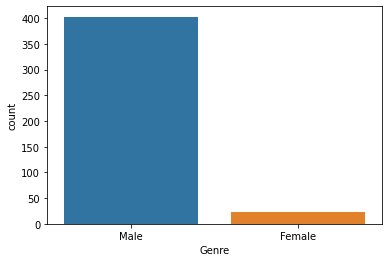

In [ ]:
# Lets check the distribution of the accidents among male and female.
sns.countplot(x=data['Genre']);

As we can see that there's a huge skew between the accidents among males and females which can be considered obvious as the number of males working in Industrial sectors are way way more than number of females.

In [ ]:
# Adds two new columns for Year wise and month wise distribution.
data['Month_Year'] = data['Data'].apply(lambda x: x[:7])
data['Year'] = data['Data'].apply(lambda x: x[:4])

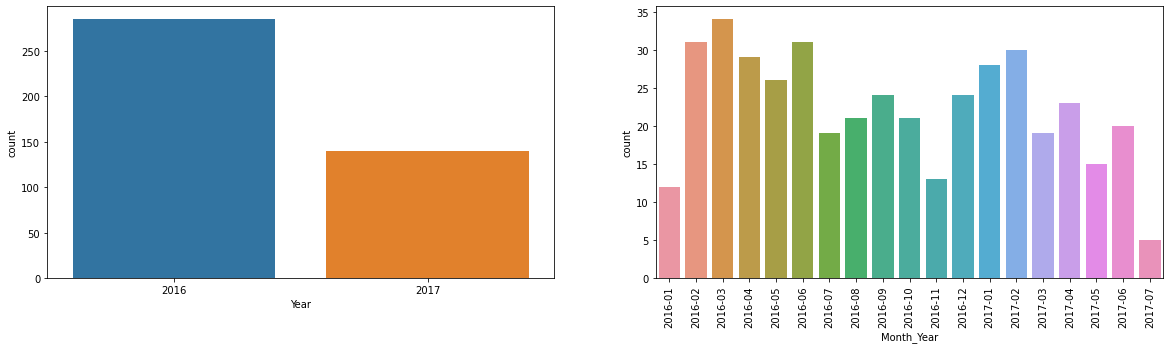

In [ ]:
plt.rcParams["figure.figsize"] = (20,5)
fig, ax = plt.subplots(1,2)
plt.xticks(rotation=90)
sns.countplot(x=data['Year'], ax=ax[0]);
sns.countplot(x=data['Month_Year'], ax=ax[1]);
fig.show()

From the above two distributions, we can see that number of accidents in 2016 were much more compared to 2017.

Also, if we see from the monthly distribution, we can see that the number of accidents are more in the month of Feb to Jun in 2016. There is no definite pattern that we can identify from this, though.

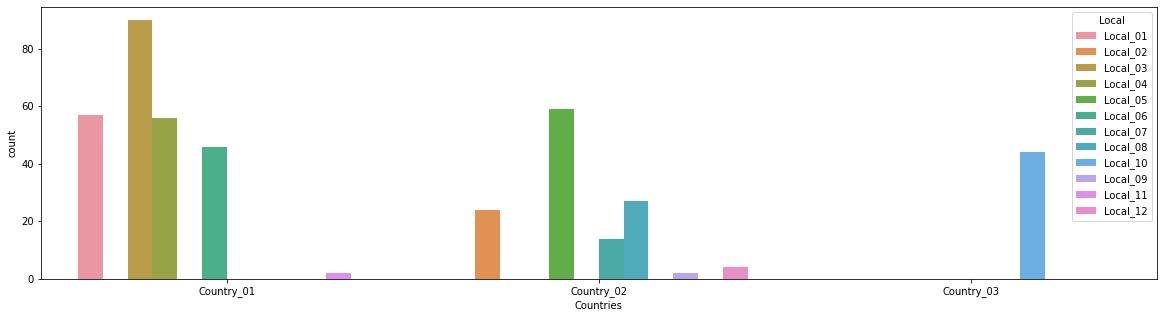

In [ ]:
sns.countplot(x=data['Countries'], hue=data['Local']);

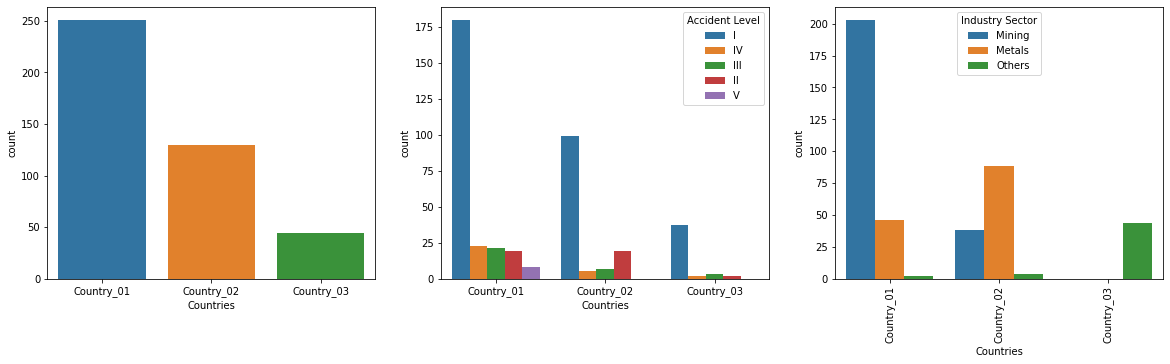

In [ ]:
fig, ax = plt.subplots(1,3)
plt.xticks(rotation=90)
sns.countplot(x=data['Countries'], ax=ax[0]);
sns.countplot(x=data['Countries'], hue=data['Accident Level'], ax=ax[1]);
sns.countplot(x=data['Countries'], hue=data['Industry Sector'], ax=ax[2]);
fig.show()

If we look at above charts, we see that Country 1 has most number of accidents and also the number of severe accidents are much more than other countries.

Country 1 is the only country which has severity V accident.

Coming to industry sector, Country 1 has most accidents in Mining whereas Country 2 has more accidents in Metals sector.

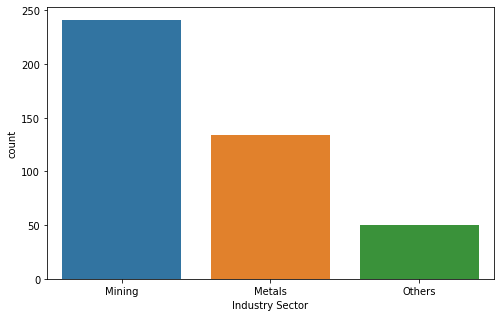

In [ ]:
# Checking the accident distribution in the industries
plt.rcParams["figure.figsize"] = (8,5)
sns.countplot(x=data['Industry Sector']);

As we can see that the highest number of accidents are happening in mining industries which has been the case, in general.

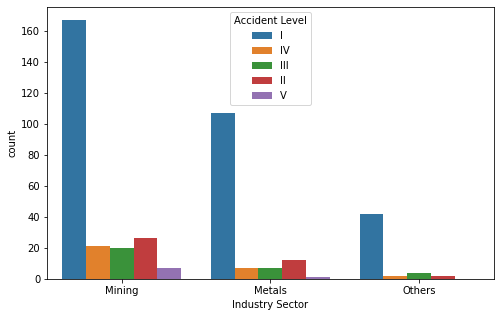

In [ ]:
#Checking how critical the accidents have been in each industry
sns.countplot(x=data['Industry Sector'], hue= data['Accident Level']);

From the above chart we can see that most of the accidents have not been severe in all the sectors. From this chart, we don't see any accident with value VI which means that there has not been a single accident which was most severe. Let's check the counts as well to verify that.

In [ ]:
data['Accident Level'].value_counts()

I      316
II      40
III     31
IV      30
V        8
Name: Accident Level, dtype: int64

The problem description says that accident level could be between I to VI, but as we can see that there is not a single accident with value VI.

Apart from that we can also see that there is a huge imbalance in the accident level distribution.

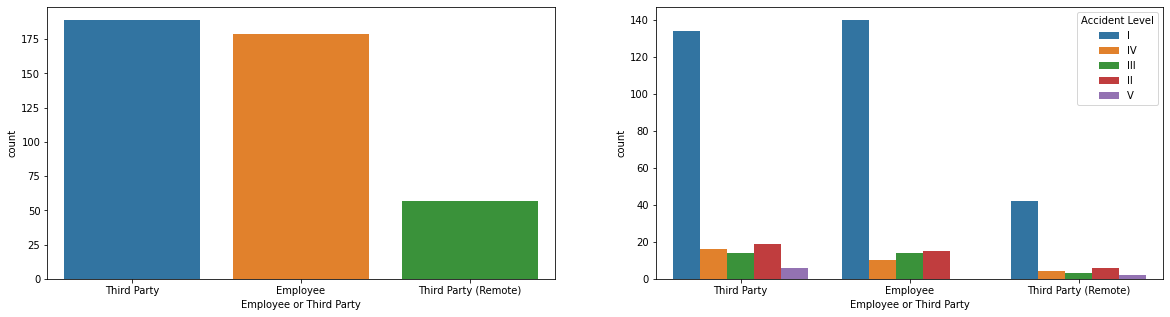

In [ ]:
plt.rcParams["figure.figsize"] = (20,5)
fig, ax = plt.subplots(1,2)
sns.countplot(x=data['Employee or Third Party'], ax=ax[0]);
sns.countplot(x=data['Employee or Third Party'], hue=data['Accident Level'], ax=ax[1]);
fig.show()

From the above two charts it is clear that the number of accidents are much more in third party compared to Employee which indicates that third party is more prone to accidents.

Also, the accident type distribution among employees and third party is same as the overall accident distribution.

Based on the EDA done above, we can make following observations:

1. Overall, there has not been a single case of most severe accident (VI) which indicates that the industries have taken appropriate measures to avoid the most severe accidents.

2. The accident level distribution is very skewed where the least severe accidents are much more compared to more severe accidents which is also a good indication that industries have taken measures to prevent severe accidents, in general or we can say that the people have also taken right precautions to avoid severe accidents, in general.

3. The distribution in males is much more compared to females, which is also expected given the nature of employment.

4. There are more accidents in third party compared to employees which can indicate two things, either the third party people does not take enough precautions or the industries does not provide enough safety measures for third party people.

5. The most number of accidents are from Country 1 which indicates that it is most prone to accidents and also it has more number of severe accidents compared to other countries. Also, Country 1 has most number of accidents in Mining sector whereas Country 2 has most in Metals sector. This indicates that Country 1 needs to take more safety measures in mining sector.

6. The number of accidents have been more in 2016 and it reduced by half in 2017 indicating that some improvement has happened in the safety measures from 2016-2017

In [ ]:
if data.duplicated().sum() > 0:
  print('Removing duplicate records')
  data.drop_duplicates(inplace=True)

In [ ]:
# Printing descriptions of a few accidents

for i in range(0,10):
  print(data['Description'][i])
  print()

While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo.

During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter.

In the sub-station MILPO located at level +170 when the collaborator was doing the excavation work with a pick (hand tool), hitting a rock with the flat part of the beak, it bounces off hitting the steel tip of the safety shoe and t

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
stopWords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
space=' '
def cleanseText(text):
  try:
    text = re.sub('[^\w\s]+', space, text)
    text = re.sub(r'\s\s+', space, text)
    text = re.sub(r'^A-Za-z]', space, text)         
    words = text.strip().lower().split()    
    words = [w for w in words if len(w)>=1]
    desc = space.join(words)
    descWords = [word.lower() for word in desc.split() if word.lower() not in stopWords]
    return space.join(descWords)
  except:
    print('Error occured during cleansing the text:', text)
    return ''

In [ ]:
# Removing the stop words and cleansing the data to be later used for training the model.
data['Description'] = data['Description'].apply(cleanseText)

In [ ]:
# Expand the short forms.
def expand(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"don\'t", "do not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"[^A-Za-z]+", " ", phrase)
    return phrase.lower()

In [ ]:
data['Description'] = data['Description'].apply(expand)

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemma(text):
  words = text.split()
  text = [lemmatizer.lemmatize(word) for word in words if word not in string.punctuation]
  return space.join(text)

In [ ]:
data['Description'] = data['Description'].apply(lemma)

In [ ]:
chk = data['Description'].apply(len)
chk.sort_values()

208     61
250     62
305     64
275     65
230     68
      ... 
156    566
371    572
338    630
79     639
174    657
Name: Description, Length: 425, dtype: int64

After cleansing, the description has minimum of 61 and maximum of 657 characters

In [ ]:
# Creating word2vec model with 50 embeddings
embeddings_index = {}
f = open(parent_dir+'glove.6B.50d.txt')

for line in f:
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
embeddings_index.get('drill')

array([-0.0055476, -0.39273  ,  0.15205  ,  0.4551   , -0.36954  ,
       -0.40238  ,  0.36912  ,  0.747    ,  0.55792  , -0.83863  ,
       -0.37462  , -0.20634  ,  0.40669  ,  1.1276   , -0.79788  ,
       -0.24294  ,  0.27706  ,  1.0719   , -1.1724   , -0.61039  ,
        0.54103  ,  0.18078  ,  0.202    , -1.0802   ,  0.58973  ,
       -0.91807  , -0.0088915,  0.059115 ,  0.47291  , -0.655    ,
        1.9677   , -0.56201  , -0.96587  ,  0.35787  ,  0.13509  ,
        0.80648  ,  0.33995  , -0.36178  ,  0.32938  ,  0.1069   ,
       -0.42603  , -0.75837  ,  0.019512 ,  0.41161  ,  0.94834  ,
       -0.72586  ,  1.4135   ,  0.69039  , -0.87651  ,  0.18577  ],
      dtype=float32)

In [ ]:
EMBEDDING_DIM = embeddings_index.get('drill').shape[0]

In [ ]:
data['Accident Level'].value_counts()

I = data[data['Accident Level']== 'I']
II = data[data['Accident Level']== 'II']
III = data[data['Accident Level']== 'III']
IV = data[data['Accident Level']== 'IV']
V = data[data['Accident Level']== 'V']


max_accidents = len(I)
I_scaled = resample(I, replace=False, n_samples=max_accidents, random_state=seed)
II_scaled = resample(II, replace=True, n_samples=max_accidents, random_state=seed)
III_scaled = resample(III, replace=True, n_samples=max_accidents, random_state=seed)
IV_scaled = resample(IV, replace=True, n_samples=max_accidents, random_state=seed)
V_scaled = resample(V, replace=True, n_samples=max_accidents, random_state=seed)

data_new = pd.concat([I_scaled, II_scaled, III_scaled, IV_scaled, V_scaled])

In [ ]:
X = data_new['Description']
y = data_new['Accident Level']

y = LabelEncoder().fit_transform(y).astype(np.int8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

In [ ]:
# Tokenizing and setting max length
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)

train_token = tokenizer.texts_to_sequences(X_train)
test_token = tokenizer.texts_to_sequences(X_test)

max_len = 200
train_padded = pad_sequences(train_token, maxlen=max_len, padding='post', truncating='post')
test_padded = pad_sequences(test_token, maxlen=max_len, padding='post', truncating='post')

In [ ]:
# Printing the vocabulary size and creating embedding matrix
embedding_matrix_row = len(tokenizer.word_index) + 1
print('No of vocabs :', embedding_matrix_row)
embedding_matrix = np.zeros((embedding_matrix_row, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

embedding_matrix.shape

No of vocabs : 2517


(2517, 50)

In [ ]:
# Running grid search with ML algorithms, printing the best params, best score, classification report
def Model_Report(X_train, y_train, X_val, y_val):

  models = ['LR', 'SVC', 'RF', 'ADA', 'ExTC', 'KNN', 'LGBM', 'XGB']

  clfs = [
          LogisticRegression(solver='liblinear', random_state=seed),
          SVC(random_state=seed, probability=True),
          RandomForestClassifier(n_jobs=10, random_state=seed),
          AdaBoostClassifier(random_state=seed),
          ExtraTreesClassifier(random_state=seed, n_jobs=10),
          KNeighborsClassifier(n_jobs=10),
          LGBMClassifier(n_jobs=10, random_state=seed),
          XGBClassifier(n_jobs=10, random_state=seed)
        ]

  params = {
          models[0]: {'penalty': ['l1', 'l2'], 'C': [0.1,1,10]},
          models[1]: {'C': [1,10], 'gamma':[0.01,0.1,1]},
          models[2]: {'n_estimators': [10, 100], 'max_depth': [10, 15]},
          models[3]: {'n_estimators': [100,200], 'learning_rate': [0.1, 1]},
          models[4]: {'n_estimators': [10, 100], 'max_depth': [10, 15]},
          models[5]: {'n_neighbors': [2, 5, 8], 'weights': ['uniform', 'distance']},
          models[6]: {'n_estimators': [100], 'learning_rate': [0.01, 0.1]},
          models[7]: {'n_estimators': [100, 200], 'gamma': [0.01, 0.1]}

      }

  result = {}

  for name, estimator in zip(models, clfs):
    print('')
    print('--'*50)
    print("Running model: " + name)

    clf = GridSearchCV(estimator, params[name], cv=5)

    clf.fit(X_train, y_train)

    print("Best params: " + str(clf.best_params_))
    print("Best score: " + str(round(clf.best_score_,3)))

    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)

    df_report = classification_report(y_val, y_pred)
    print(df_report)

    clf_train_score = round(clf.best_score_,3)
    clf_recall = round((metrics.recall_score(y_val, y_pred, average='weighted')), 3)   
    clf_precision = round((metrics.precision_score(y_val, y_pred, average='weighted')), 3) 
    clf_f1score = round((metrics.f1_score(y_val, y_pred, average='weighted')),3)
      
    result[name] = [clf_train_score, acc, clf_recall, clf_precision, clf_f1score]

  result_tab = pd.DataFrame(np.array(list(result.values()))[:,:],
                          columns= ['Training Score', 'Accuracy', 'Recall', 'Precision', 'F1 score'],
                        index= result.keys())

  result_tab.index.name = 'Model_Name'

  return result_tab, clf

In [ ]:
# Train ML model, print classification report, summmarized table
result, clf= Model_Report(train_padded, y_train, test_padded, y_test)
print('--'*50)
print()
result


----------------------------------------------------------------------------------------------------
Running model: LR
Best params: {'C': 1, 'penalty': 'l1'}
Best score: 0.747
              precision    recall  f1-score   support

           0       0.46      0.33      0.38        94
           1       0.60      0.62      0.61        95
           2       0.76      0.77      0.76        95
           3       0.80      0.85      0.83        95
           4       0.86      1.00      0.92        95

    accuracy                           0.72       474
   macro avg       0.70      0.71      0.70       474
weighted avg       0.70      0.72      0.70       474


----------------------------------------------------------------------------------------------------
Running model: SVC
Best params: {'C': 1, 'gamma': 0.01}
Best score: 0.991
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        94
           1       1.00      0.92      0.96      

,Training Score,Accuracy,Recall,Precision,F1 score
Model_Name,,,,,
LR,0.747,0.715190,0.715,0.696,0.702
SVC,0.991,0.983122,0.983,0.984,0.983
RF,0.986,0.981013,0.981,0.982,0.981
ADA,0.722,0.694093,0.694,0.696,0.694
ExTC,0.987,0.962025,0.962,0.962,0.962
KNN,0.881,0.869198,0.869,0.869,0.852
LGBM,0.987,0.943038,0.943,0.942,0.941
XGB,0.983,0.943038,0.943,0.944,0.941


In [ ]:
# Creating an SVC model with the best params and fitting to be pickled for later use.
svcModel = SVC(random_state=seed, probability=True, C=1, gamma=0.01)
svcModel.fit(train_padded, y_train)

SVC(C=1, gamma=0.01, probability=True, random_state=7)

In [ ]:
# Pickle the ML model for later use
pickledModel = parent_dir+'Capstone_ML.sav'
pickle.dump(svcModel, open(pickledModel, 'wb'))

In [ ]:
input = Input(shape=(max_len,), name='input')

embedding = Embedding(input_dim=embedding_matrix_row,
                      output_dim=EMBEDDING_DIM,
                      weights= [embedding_matrix],
                      trainable = False)(input)

bidirectional = Bidirectional(LSTM(64, return_sequences=True))(embedding)

timeDistributed = TimeDistributed(Dense(32, activation='relu'))(bidirectional)

flatten = Flatten()(timeDistributed)

dropout = Dropout(.4)(flatten)
activation = Activation("relu")(dropout)

output = Dense(5, activation='softmax', name = "output")(activation)

model = Model(inputs = input, outputs = output)

model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 200, 50)           125850    
                                                                 
 bidirectional_4 (Bidirectio  (None, 200, 128)         58880     
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 200, 32)          4128      
 tributed)                                                       
                                                                 
 flatten_4 (Flatten)         (None, 6400)              0         
                                                                 
 dropout_4 (Dropout)         (None, 6400)              0   

Epoch 1/50
10/12 [========================>.....] - ETA: 0s - loss: 1.5089 - accuracy: 0.3920
Epoch 00001: val_loss improved from inf to 1.29268, saving model to model-cap.h5
12/12 [==============================] - 4s 104ms/step - loss: 1.4913 - accuracy: 0.4024 - val_loss: 1.2927 - val_accuracy: 0.5612
Epoch 2/50
10/12 [========================>.....] - ETA: 0s - loss: 1.1999 - accuracy: 0.5990
Epoch 00002: val_loss improved from 1.29268 to 1.01567, saving model to model-cap.h5
12/12 [==============================] - 0s 26ms/step - loss: 1.1914 - accuracy: 0.5986 - val_loss: 1.0157 - val_accuracy: 0.5802
Epoch 3/50
10/12 [========================>.....] - ETA: 0s - loss: 0.9785 - accuracy: 0.5970
Epoch 00003: val_loss improved from 1.01567 to 0.83053, saving model to model-cap.h5
12/12 [==============================] - 0s 27ms/step - loss: 0.9736 - accuracy: 0.5931 - val_loss: 0.8305 - val_accuracy: 0.7068
Epoch 4/50
10/12 [========================>.....] - ETA: 0s - loss: 0.7962 -

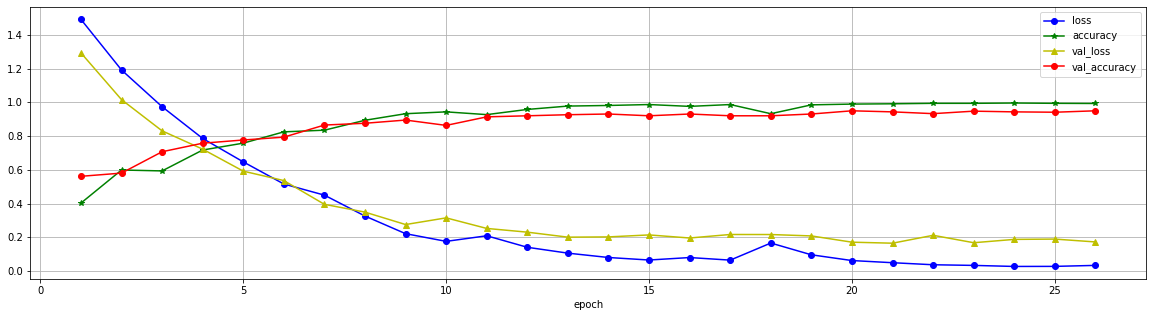

In [ ]:
# Check if trained model already exists, if it does, load the weights, otherwise train and plot the figure

savedModel = parent_dir+'Capstone_NN_weights.h5'

if os.path.isfile(savedModel):
  model.load_weights(savedModel)
else:
  mc = ModelCheckpoint("model-cap.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True, mode="min")
  es = EarlyStopping(monitor="val_loss", patience=5, mode="min")
  history = model.fit(train_padded, y_train, 
                    validation_data = (test_padded, y_test), 
                    epochs = 50,
                    batch_size = 100,
                    callbacks = [mc, es])
  
  plt.figure()
  L = len(history.history["loss"]) + 1
  plt.plot(range(1, L), history.history["loss"], "bo-", label = "loss")
  plt.plot(range(1, L), history.history["accuracy"], "g*-", label = "accuracy")
  plt.plot(range(1, L), history.history["val_loss"], "y^-", label = "val_loss")
  plt.plot(range(1, L), history.history["val_accuracy"], "ro-", label = "val_accuracy")
  plt.legend()
  plt.xlabel("epoch")
  plt.grid()
  plt.show()

  model.save(savedModel.replace('_weights', ''))
  model.save_weights(savedModel)

Based on the above run, we can see that we have got 95%+ accuracy which seems to be good.

As we can see from the above runs, both ML models and NN models are performing really well and have good training/validation accuracy.


Out of the two, we would prefer ML model, specifically either SVC or RF as those models are performing best among all the models.

## **Creating a FLASK APP to predict accident severity**

In [ ]:
# This method processes the input and prepares it to be passed to the model for prediction.
def prepareAndProcess(pred_text):
  pred_text = cleanseText(pred_text)
  pred_text = expand(pred_text)
  pred_text = lemma(pred_text)
  pred_token = tokenizer.texts_to_sequences([pred_text])
  pred_padded = pad_sequences(pred_token, maxlen=max_len, padding='post', truncating='post')
  return pred_padded

In [ ]:
!pip install flask-ngrok
!pip install flask-bootstrap
!pip install pyngrok

from flask_ngrok import run_with_ngrok
from flask import Flask, render_template , request

In [ ]:
# Sign-up to ngrok.com and replace XXXX with your auth token to open a tunnel to the locally deployed app.
!ngrok authtoken XXXX

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
# This method takes in the input text and processes it to be passed to the model and then predict the outcome using SVC model.
def predict(text):
  pred_padded = prepareAndProcess(text)
  svcModel = pickle.load(open(pickledModel, 'rb'))
  prediction = svcModel.predict(pred_padded)[0]

  if(prediction == 0):
    return 'Predicted Accident Level: I'
  elif(prediction == 1):
    return 'Predicted Accident Level: II'
  elif(prediction == 2):
    return 'Predicted Accident Level: III'
  elif(prediction == 3):
    return 'Predicted Accident Level: IV'
  elif(prediction == 4):
    return 'Predicted Accident Level: V'

In [ ]:
# Creating a flask app, loading the template and CSS from the below locations and running the app with ngrok

app = Flask(__name__, template_folder=parent_dir+'templates')
app.static_folder = parent_dir+'static'

run_with_ngrok(app)
@app.route("/")
def home():
    return render_template("index.html")

@app.route("/get")
def get_bot_response():
    userText = request.args.get('msg')
    return predict(userText)

if __name__ == '__main__':
   app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://302d-35-187-152-57.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [03/Jan/2022 13:14:40] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Jan/2022 13:14:41] "GET /static/styles/style.css HTTP/1.1" 200 -
127.0.0.1 - - [03/Jan/2022 13:14:42] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [03/Jan/2022 13:14:44] "GET /get?msg=While%20removing%20the%20drill%20rod%20of%20the%20Jumbo%2008%20for%20maintenance%2C%20the%20supervisor%20proceeds%20to%20loosen%20the%20support%20of%20the%20intermediate%20centralizer%20to%20facilitate%20the%20removal%2C%20seeing%20this%20the%20mechanic%20supports%20one%20end%20on%20the%20drill%20of%20the%20equipment%20to%20pull%20with%20both%20hands%20the%20bar%20and%20accelerate%20the%20removal%20from%20this%2C%20at%20this%20moment%20the%20bar%20slides%20from%20its%20point%20of%20support%20and%20tightens%20the%20fingers%20of%20the%20mechanic%20between%20the%20drilling%20bar%20and%20the%20beam%20of%20the%20jumbo. HTTP/1.1" 200 -
